### Inversion for elastic tensor with 7C seismometer

The inversion for the elastic tensor heavily relies on the estimation of the qP-velocity. Estimating this velocity is for translational and rotational sensors only possible if the qP's rotational signal is measured. However, it's magnitude is dwarfed against shear wave rotations and applying some noise to the data will lead to poor qP-velocity estimations. This is due to the nature of rotational motions that the ratio between rotational and translational components is only truely fit to determine shear wave velocities. Looking onto another technique, strain measurments are better suited to estimate pressure wave velocities.

In fact, it's already possible to do that with just one additional strain (rate) component. We choose $\dot\epsilon_{zz}$, the vertical component, as it is the most commonly measured direction in a bore hole.

It can be written down as:

$
\dot\epsilon_{zz} = -\frac{A\omega^2}{v}\nu_zn_z\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

We know the propagation direction $\nu$ from the polarization of rotational measurements. To extract the velocity $v$ from it, we cannot rotate the strainmeter as we do not have the complete measurements. Comparing it with the vertical translational component:

$
\ddot u_z = -A\omega^2n_z\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

we can calculcate the ratio:

$
\frac{\ddot u_z \nu_z}{\dot\epsilon_{zz}} = \frac{\ddot u_z}{\dot\epsilon_{zz}}\cos\theta = v
$
---

Noticeably, all three data types are combined to derive a single metric. It's best suited for waves coming in steep. The estimation with rotation rates is the same in all directions, so for waves with $\theta>75^\circ$ the rotation method is applied. 

Shear wave velocities are still computed using ratios between rotational and translational components.


During the inversion, unrealisitic p-wave velocities are not considered. If either the p-wave velocity is smaller than one of the shear wave velocity or three times greater, the event is discarded.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *
from scipy.signal import butter,filtfilt
from scipy.linalg import null_space

In [2]:
def estimate_velocity_7C(seis, nu,t, min_vertical):
    nt = len(seis[0,:])
    r2d = 180/np.pi 
    d2r = 1/r2d
    theta, phi = get_angles(nu)
    R = np.zeros((3,3))
    r = [(1. + np.cos(phi)*np.sin(theta))/2,\
         (np.sin(phi)*np.sin(theta))/2,\
         np.cos(theta)/2]
    r_sum = 0
    for i in range(0,3):
        r_sum += r[i]**2
    for i in range(0,3):
        r[i] = r[i]/np.sqrt(r_sum)
        
    K_sq = [[-r[1]**2-r[2]**2,r[0]*r[1],r[0]*r[2]], \
            [r[0]*r[1],-r[0]**2-r[2]**2,r[1]*r[2]], \
            [r[0]*r[2],r[1]*r[2],-r[0]**2-r[1]**2]]
    
    R[0,0] = 1 + 2*K_sq[0][0]
    R[1,0] = 2*K_sq[1][0]
    R[2,0] = 2*K_sq[2][0]

    R[0,1] = 2*K_sq[0][1]
    R[1,1] = 1 + 2*K_sq[1][1]
    R[2,1] = 2*K_sq[2][1]

    R[0,2] = 2*K_sq[0][2]
    R[1,2] = 2*K_sq[1][2]
    R[2,2] = 1 + 2*K_sq[2][2]
    
    seis_new = np.zeros((6,nt))
    
    for k in range(0,3):
        seis_new[k,:]   = R[k,0]*seis[0,:]+R[k,1]*seis[1,:]+R[k,2]*seis[2,:]
        seis_new[k+3,:] = R[k,0]*seis[3,:]+R[k,1]*seis[4,:]+R[k,2]*seis[5,:]
    
    
    ip = np.argmax(seis_new[0,:])
    uz = seis[2,ip]
    ezz = seis[6,ip]
    if (theta*r2d) < min_vertical:
        qP = abs(uz*np.cos(theta) / ezz)
    else:
        uy = seis_new[1,ip]
        uz = seis_new[2,ip]
        ry = seis_new[4,ip]
        rz = seis_new[5,ip]

        qP = .5 * np.sqrt(uy**2+uz**2)/np.sqrt(ry**2+rz**2)
    
    nang = 721
    xc  = np.zeros(nang)
    ang = np.linspace(0,180,nang)
    d2r = r2d**-1

    for i in range(nang):
        angle = ang[i]
        xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
        yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]
        junk = np.corrcoef(xr, yr)
        xc[i] = junk[1,0]
        ang[i] = angle
        
    imax = np.argmax(xc)
    imax2 = np.argmin(xc)
    if abs(imax)<abs(imax2):
        imax = imax2
    amax = ang[imax]
    
    angle = amax
    xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
    yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]
    
    seis_new[1,:] = xr
    seis_new[2,:] = yr
    
    xrr = np.cos(angle*d2r)*seis_new[4,:] -  np.sin(angle*d2r)*seis_new[5,:]
    yrr = np.sin(angle*d2r)*seis_new[4,:] +  np.cos(angle*d2r)*seis_new[5,:]
    
    seis_new[4,:] = xrr
    seis_new[5,:] = yrr
    
    R2 = np.array([[1,0,0],[0,np.cos(angle*d2r),-np.sin(angle*d2r)],[0,np.sin(angle*d2r),np.cos(angle*d2r)]])
    R = np.dot(R,R2.transpose())
        
    j1 = np.argmax(xrr)
    j1c = np.argmin(xrr)
    j2 = np.argmax(yrr)
    j2c = np.argmin(yrr)
    qS1 = abs(yr[j1]/xrr[j1])/2
    qS2 = abs(xr[j2]/yrr[j2])/2
    
    safety = nt//100
    if abs(j1-j2)<safety or abs(j1-j2c)<safety or abs(j1c-j2)<safety:    # if picks are from same peak!
        angle = 45.
        xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
        yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]

        seis_new[1,:] = xr
        seis_new[2,:] = yr

        xrr = np.cos(angle*d2r)*seis_new[4,:] -  np.sin(angle*d2r)*seis_new[5,:]
        yrr = np.sin(angle*d2r)*seis_new[4,:] +  np.cos(angle*d2r)*seis_new[5,:]

        seis_new[4,:] = xrr
        seis_new[5,:] = yrr

        R2 = np.array([[1,0,0],[0,np.cos(angle*d2r),-np.sin(angle*d2r)],[0,np.sin(angle*d2r),np.cos(angle*d2r)]])
        R = np.dot(R,R2.transpose())
        
        j1 = np.argmax(xrr)
        j2 = np.argmax(yrr)
        qS1 = abs(yr[j1]/xrr[j1])/2
        qS2 = abs(xr[j2]/yrr[j2])/2
    
        
    if qS1<qS2:
        qS1, qS2 = qS2, qS1
    
    vel_e = [qP, qS1, qS2]
    
    return vel_e, seis_new, R

In [3]:
medium = load_medium_list()
print(' ')
rand_med = load_random_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz
#7 Baird-shale
 
 
#0 isotropic
#1 cubic
#2 VTI
#3 tetragonal
#4 trigonal
#5 orthorhombic
#6 monoclinic
#7 triclinic


In [4]:
C, density = get_specific_VTI(medium[1])
#C, density = get_random_C(rand_med[5],20)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


x 2
y 3
z 1
Originial data


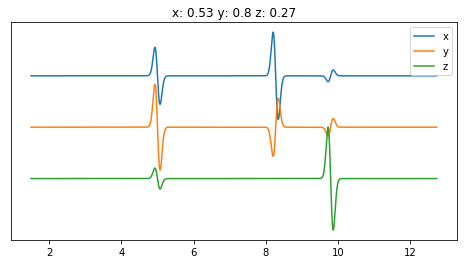

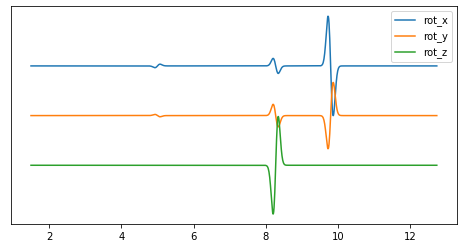

Rotated data


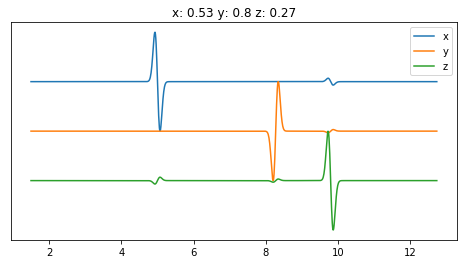

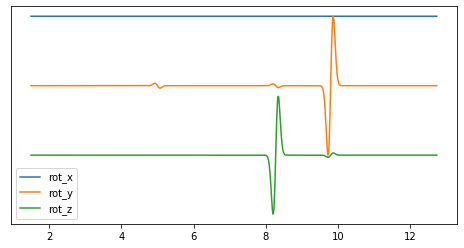

Estimated velocities: 
676.1106995650335 2220.236825044958 1875.4421901143535
Actual velocities: 
3672.6939793324436 2220.236825044958 1875.442190114354
Relative error (order of magnitude)
-0.09
machine precision
-15.65


In [5]:
f = 10.
fs = 100.
plot_original_seismo = True
plot_rotated_seismo = True

nus,gammas = get_direction('input', C,1 )
vel,v = get_eigenvals(gammas[0], density)
seis, t = get_seis_strain(v, vel, nus[0], f,fs)

vel_s = extract_slower_velocities(vel)
if plot_original_seismo:
    print('Originial data')
    plotseis(seis,t,nus[0])
nu_e = get_propagation_direction(seis,f,fs)
vel_e, seis_rot , _ = estimate_velocity_7C(seis, nus[0],t,90.)
if plot_rotated_seismo:
    print('Rotated data')
    plotseis(seis_rot,t,nus[0])

print('Estimated velocities: ')
print(vel_e[0],vel_e[1],vel_e[2])
print('Actual velocities: ')
print(max(vel),vel_s[0],vel_s[1])
print('Relative error (order of magnitude)')
e0 = abs(vel_e[0]/max(vel)-1)
e1 = abs(vel_e[1]/vel_s[0]-1)
e2 = abs(vel_e[2]/vel_s[1]-1)
if e0!=0.0:
    print(round(np.log10(e0),2))
else:
    print('machine precision')
if e1!=0.0:
    print(round(np.log10(e1),2))
else:
    print('machine precision')
if e2!=0.0:
    print(round(np.log10(e2),2))
else:
    print('machine precision')

### Comparison 7C -- 6C

In [6]:
f = 15.
fs = 100.
SNR_dB_u = 10.
SNR_dB_r = 5.
SNR_dB_s = 5.
N = 25 # shots per inversion
Ninv = 50  # repetition of inversion
mode = 'triclinic'
minangle = 60
ang1 = 0.
ang2 = 0.
ang3 = 0.

errorcounter = 0
C_e = np.zeros((Ninv,6,6))
C_e2 = np.zeros((Ninv,6,6))

C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

for j in range(0,Ninv):
    nus, gammas = get_direction('random',C,N)
    d = np.array([])
    G = np.array([])
    d2 = np.array([])
    G2 = np.array([])
    for i in range(0,N):
        vel, v = get_eigenvals(gammas[i], density)
        seis, t = get_seis_strain(v,vel,nus[i],f,fs) 
        seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=SNR_dB_s)
        seis = np.array([seis[0,:],seis[1,:],seis[2,:],seis[3,:],seis[4,:],seis[5,:],seis[8,:]])
        try: #every thousandth direction there's one that fails for some reason
            n_trans = get_polarizations(seis,'nav') 
            nu_e = get_propagation_direction(seis,f,fs)
            vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t,minangle)
            if vel_e[0]==0. or vel_e[0]/3 >vel_e[1]:# or nu_e[2]<np.cos(minangle*np.pi/180):# or vel_e[0]<vel_e[1]:
                pass
            else:
                d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
            vel_e2,_,_ = estimate_velocity(seis,nu_e,t)
            if vel_e2[0]==0. or vel_e2[0]/3 >vel_e2[1]:# or nu_e[2]<np.cos(minangle*np.pi/180):# or vel_e[0]<vel_e[1]:
                pass
            else:
                d2,G2 = add_new_data(mode,d2,G2,nu_e,vel_e2,n_trans,density)    
        except:
            errorcounter += 1

    Q = np.linalg.inv(np.dot(G.transpose(),G))         
    m = np.dot(np.dot(Q,G.transpose()),d)
    C_e[j,:,:] = sort_elastic_coeff(mode,m)  
    
    Q2 = np.linalg.inv(np.dot(G2.transpose(),G2))         
    m2 = np.dot(np.dot(Q2,G2.transpose()),d2)
    C_e2[j,:,:] = sort_elastic_coeff(mode,m2)  
    
C = rotate_C(C,3,-ang3)
C = rotate_C(C,2,-ang2)
C = rotate_C(C,1,-ang1)

for i in range(0,np.shape(C_e)[0]):
    C_e[i,:,:] = rotate_C(C_e[i,:,:],3,-ang3)
    C_e[i,:,:] = rotate_C(C_e[i,:,:],2,-ang2)
    C_e[i,:,:] = rotate_C(C_e[i,:,:],1,-ang1)
    
for i in range(0,np.shape(C_e2)[0]):
    C_e2[i,:,:] = rotate_C(C_e2[i,:,:],3,-ang3)
    C_e2[i,:,:] = rotate_C(C_e2[i,:,:],2,-ang2)
    C_e2[i,:,:] = rotate_C(C_e2[i,:,:],1,-ang1)    

print(str(errorcounter)+' failed events.')    

0 failed events.


0 estimates stripped
0 estimates stripped


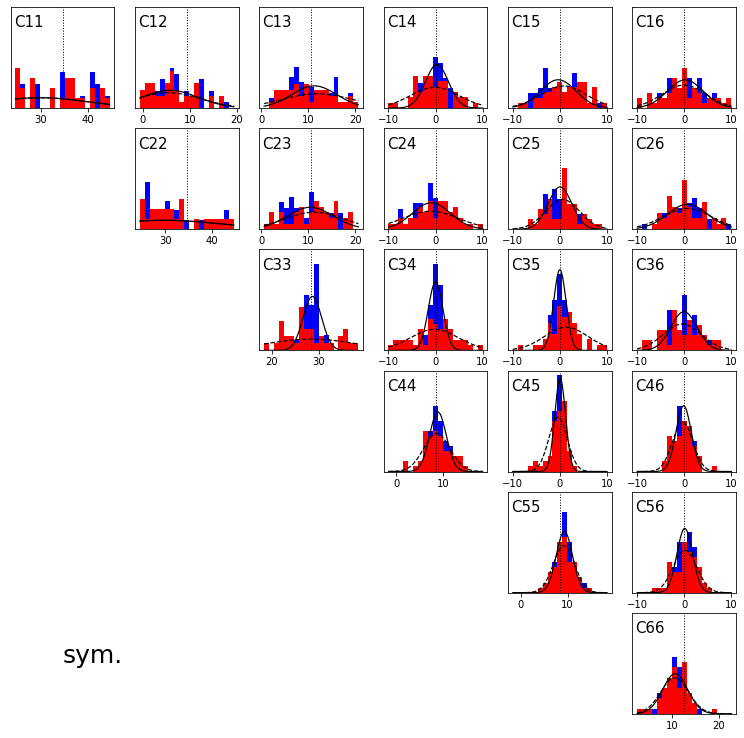

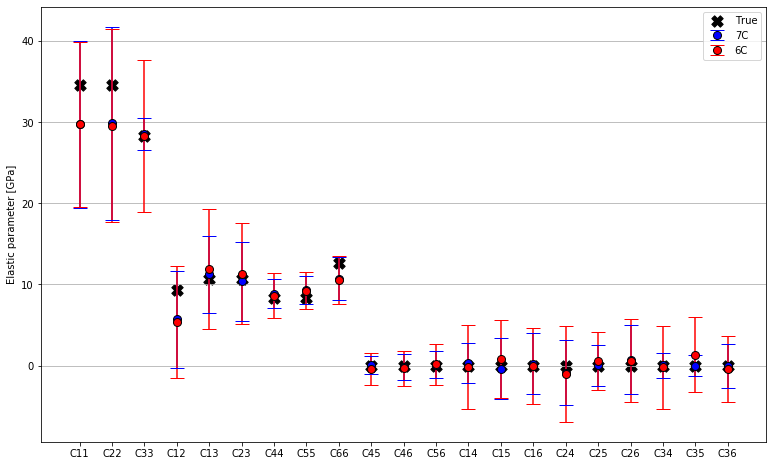

In [7]:
fac = 1e-9 ##conversion to GPa
width = 10.
Nplot = 1000
nbins = 19
save = False
savename = ' '

param = [['C11','C12','C13','C14','C15','C16'],\
         ['C00','C22','C23','C24','C25','C26'],\
         ['C00','C00','C33','C34','C35','C36'],\
         ['C00','C00','C00','C44','C45','C46'],\
         ['C00','C00','C00','C00','C55','C56'],\
         ['C00','C00','C00','C00','C00','C66']]

fig, ax = plt.subplots(ncols=6,nrows=6, figsize=(13,13),sharey=True)

width *= 1e9*fac
    # get rid of potential 'nan' in estimations
i1, i2, i3 = np.shape(C_e)
C_e_stripped = []
for i in range(i1):
    c = 0
    for j in range(i2):
        for k in range(i3):
            if not np.isnan(C_e[i,j,k]) and not C_e[i,j,k]==0.0: c+=1
    if c==36:
        C_e_stripped.append(C_e[i,:,:])
print(str(Ninv - np.shape(C_e_stripped)[0])+' estimates stripped')
C_e_stripped = np.array(C_e_stripped)

i1, i2, i3 = np.shape(C_e2)
C_e2_stripped = []
for i in range(i1):
    c = 0
    for j in range(i2):
        for k in range(i3):
            if not np.isnan(C_e2[i,j,k]) and not C_e2[i,j,k]==0.0: c+=1
    if c==36:
        C_e2_stripped.append(C_e2[i,:,:])
print(str(Ninv - np.shape(C_e2_stripped)[0])+' estimates stripped')
C_e2_stripped = np.array(C_e2_stripped)

mu = np.zeros((6,6))
sig = np.zeros((6,6))
for i in range(0,6):
    for j in range(i,6):
        n = len(C_e_stripped[:,i,j])
        mu[i,j] = 1/n * np.sum(C_e_stripped[:,i,j]*fac) 
        sig[i,j] = 1/n * np.sum((C_e_stripped[:,i,j]*fac-mu[i,j])**2)

mu2 = np.zeros((6,6))
sig2 = np.zeros((6,6))
for i in range(0,6):
    for j in range(i,6):
        n = len(C_e2_stripped[:,i,j])
        mu2[i,j] = 1/n * np.sum(C_e2_stripped[:,i,j]*fac) 
        sig2[i,j] = 1/n * np.sum((C_e2_stripped[:,i,j]*fac-mu2[i,j])**2)
        

for i in range(0,6):
    for j in range(0,6):
        if i<=j:
            hist_range = [C[i,j]*fac-width,C[i,j]*fac+width]
            x = np.linspace(hist_range[0],hist_range[1],Nplot)
            y = 1/np.sqrt(2*np.pi*sig[i,j])*np.e**(-1/(2*sig[i,j])*(x-mu[i,j])**2)
            y2 = 1/np.sqrt(2*np.pi*sig2[i,j])*np.e**(-1/(2*sig2[i,j])*(x-mu2[i,j])**2)
            ax[i,j].hist(C_e_stripped[:,i,j]*fac,bins=nbins,color='blue',density=True, range=hist_range)
            ax[i,j].hist(C_e2_stripped[:,i,j]*fac,bins=nbins,color='red',density=True, range=hist_range)
            ax[i,j].set_yticks([])
            ax[i,j].axvline(C[i,j]*fac,linestyle='dotted',c='black',linewidth=1.)
            #ax[i,j].axvline(mu[i,j],linestyle='dashed',c='black')
            #ax[i,j].axvline(mu2[i,j],linestyle='dashed',c='black')
            ax[i,j].plot(x,y,color='black',linestyle='solid',linewidth=1.2)
            ax[i,j].plot(x,y2,color='black',linestyle='dashed',linewidth=1.2)
            ax[i,j].text(0.03,0.8,param[i][j],transform = ax[i,j].transAxes,fontsize=15)
        else:
            ax[i,j].set_axis_off()
            if i==5 and j==0:
                ax[i,j].text(0.5,0.5,'sym.',transform = ax[i,j].transAxes,fontsize=25)
if save:
    plt.savefig(savename+'_tri.png')
plt.plot()
    
param = ['C11','C22','C33','C12','C13','C23','C44','C55','C66','C45','C46','C56','C14','C15','C16','C24',\
         'C25','C26','C34','C35','C36']
c_true = np.array([C[0,0],C[1,1],C[2,2],C[0,1],C[0,2],C[1,2],C[3,3],C[4,4],C[5,5],C[3,4],C[3,5],C[4,5],C[0,3],C[0,4],\
              C[0,5],C[1,3],C[1,4],C[1,5],C[2,3],C[2,4],C[2,5]])*1e-9
c_est = np.array([mu[0,0],mu[1,1],mu[2,2],mu[0,1],mu[0,2],mu[1,2],mu[3,3],mu[4,4],mu[5,5],mu[3,4],\
             mu[3,5],mu[4,5],mu[0,3],mu[0,4],mu[0,5],mu[1,3],mu[1,4],mu[1,5],mu[2,3],mu[2,4],\
             mu[2,5]])
c_err = np.sqrt(np.array([sig[0,0],sig[1,1],sig[2,2],sig[0,1],sig[0,2],sig[1,2],sig[3,3],sig[4,4],sig[5,5],sig[3,4],\
             sig[3,5],sig[4,5],sig[0,3],sig[0,4],sig[0,5],sig[1,3],sig[1,4],sig[1,5],sig[2,3],sig[2,4],\
             sig[2,5]]))
c_est2 = np.array([mu2[0,0],mu2[1,1],mu2[2,2],mu2[0,1],mu2[0,2],mu2[1,2],mu2[3,3],mu2[4,4],mu2[5,5],mu2[3,4],\
             mu2[3,5],mu2[4,5],mu2[0,3],mu2[0,4],mu2[0,5],mu2[1,3],mu2[1,4],mu2[1,5],mu2[2,3],mu2[2,4],\
             mu2[2,5]])
c_err2 = np.sqrt(np.array([sig2[0,0],sig2[1,1],sig2[2,2],sig2[0,1],sig2[0,2],sig2[1,2],sig2[3,3],sig2[4,4],sig2[5,5],sig2[3,4],\
             sig2[3,5],sig2[4,5],sig2[0,3],sig2[0,4],sig2[0,5],sig2[1,3],sig2[1,4],sig2[1,5],sig2[2,3],sig2[2,4],\
             sig2[2,5]]))

plt.figure(figsize=(13,8))
plt.errorbar(param,c_est,yerr=c_err,label='7C',color='blue',fmt='o',ms=8,capsize=7,mfc='blue',mec='black')
plt.errorbar(param,c_est2,yerr=c_err2,label='6C',color='red',fmt='o',ms=8,capsize=7,mfc='red',mec='black')
plt.scatter(param,c_true,color='black',marker='X',label='True',s=130,edgecolors='black')
plt.grid(axis='y')
plt.ylabel('Elastic parameter [GPa]')
plt.legend(loc=1)
if save:
    plt.savefig(savename+'_err.png')
plt.show()

### How the threshold verticle angle for using strain rates for qP-velocity estimation influences the data

Using the vertical strain component makes the velocity estimation in this direction possible. However, the closer the incident angle moves to the horizontal plane the less signal can be expected on the strainmeter ... it may be swallowed by noise. Therefore, a threshold angle is introduced with separates the estimation utilizing strainmeter and rotational sensor. 

In [8]:
f = 15.
fs = 100.
SNR_dB_u = 10.
SNR_dB_r = 5.
SNR_dB_s = 5.
N = 40 # shots per inversion
Ninv = 50  # repetition of inversion
mode = 'triclinic'
minangle = [0,30,60,90]
Nang = len(minangle)
ang1 = 0.
ang2 = 0.
ang3 = 0.

errorcounter = 0
C_e = np.zeros((Nang,Ninv,6,6))

C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

for k in range(0,Nang):
    for j in range(0,Ninv):
        nus, gammas = get_direction('random',C,N)
        d = np.array([])
        G = np.array([])
        for i in range(0,N):
            vel, v = get_eigenvals(gammas[i], density)
            seis, t = get_seis_strain(v,vel,nus[i],f,fs) 
            seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=SNR_dB_s)
            seis = np.array([seis[0,:],seis[1,:],seis[2,:],seis[3,:],seis[4,:],seis[5,:],seis[8,:]])
            try: #every thousandth direction there's one that fails for some reason
                n_trans = get_polarizations(seis,'nav') 
                nu_e = get_propagation_direction(seis,f,fs)
                vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t,minangle[k])
                if vel_e[0]==0. or vel_e[0]/3 >vel_e[1]:# or nu_e[2]<np.cos(minangle*np.pi/180):# or vel_e[0]<vel_e[1]:
                    pass
                else:
                    d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
            except:
                errorcounter += 1

        Q = np.linalg.inv(np.dot(G.transpose(),G))         
        m = np.dot(np.dot(Q,G.transpose()),d)
        C_e[k,j,:,:] = sort_elastic_coeff(mode,m)  

    
C = rotate_C(C,3,-ang3)
C = rotate_C(C,2,-ang2)
C = rotate_C(C,1,-ang1)

for i in range(0,np.shape(C_e)[0]):
    for j in range(0,np.shape(C_e)[1]):
        C_e[i,j,:,:] = rotate_C(C_e[i,j,:,:],3,-ang3)
        C_e[i,j,:,:] = rotate_C(C_e[i,j,:,:],2,-ang2)
        C_e[i,j,:,:] = rotate_C(C_e[i,j,:,:],1,-ang1)

print(str(errorcounter)+' failed events.')    

0 failed events.


[0, 30, 60, 90]


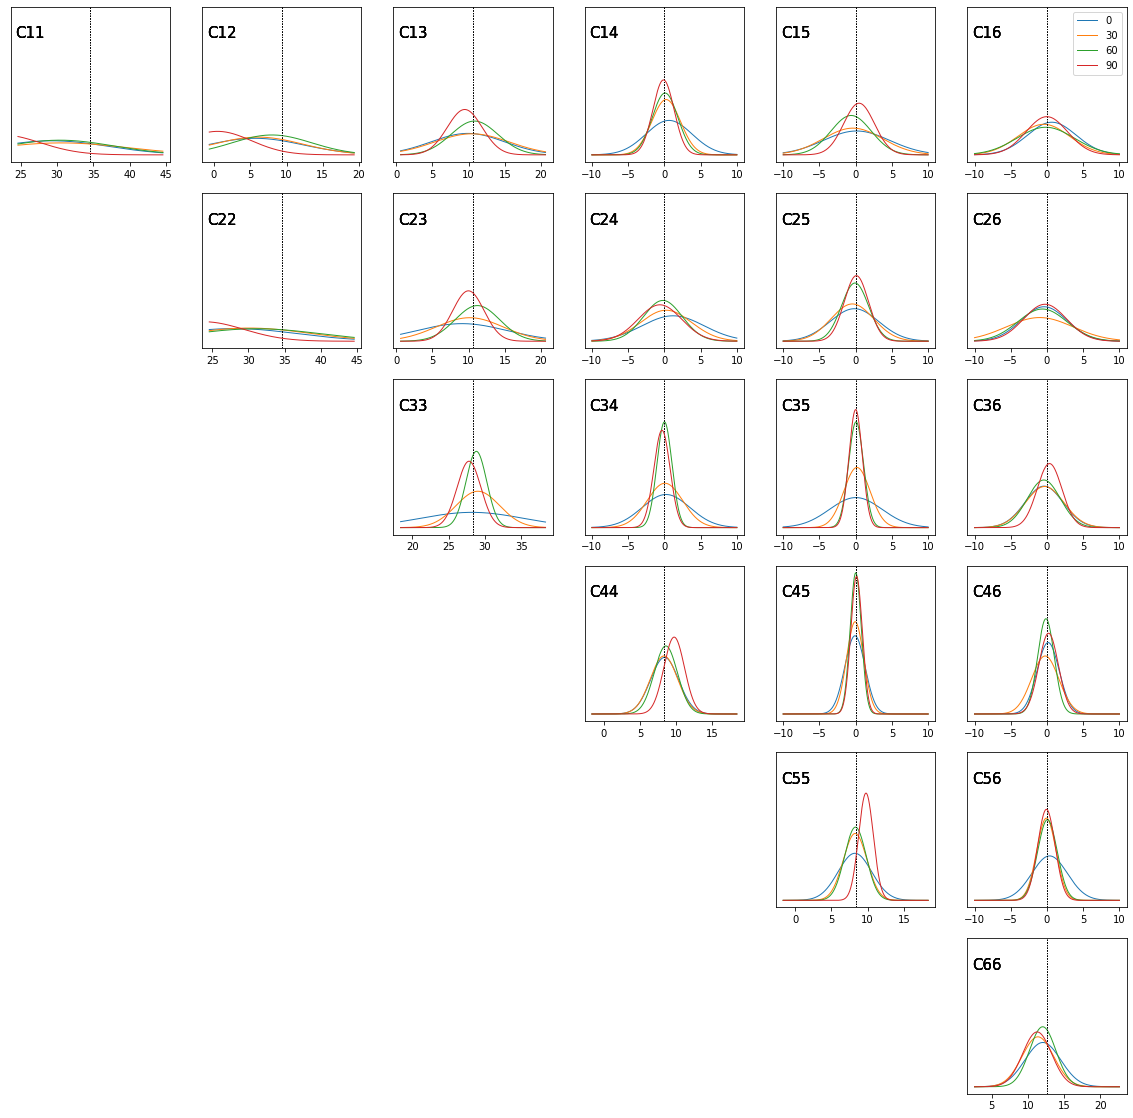

In [9]:
plotrange = [0,Nang]
fac = 1e-9 ##conversion to GPa
width = 10.
Nplot = 1000
nbins = 19
save = False
savename = ' '

param = [['C11','C12','C13','C14','C15','C16'],\
         ['C00','C22','C23','C24','C25','C26'],\
         ['C00','C00','C33','C34','C35','C36'],\
         ['C00','C00','C00','C44','C45','C46'],\
         ['C00','C00','C00','C00','C55','C56'],\
         ['C00','C00','C00','C00','C00','C66']]

print(minangle)

fig, ax = plt.subplots(ncols=6,nrows=6, figsize=(20,20),sharey=True)

width *= 1e9*fac
    # get rid of potential 'nan' in estimations 
C_e_stripped = []    
for l in range(0,np.shape(C_e)[0]):    
    i1, i2, i3 = np.shape(C_e[l,:,:,:])
    C_e_min = []
    for i in range(i1):
        c = 0
        for j in range(i2):
            for k in range(i3):
                if not np.isnan(C_e[l,i,j,k]) and not C_e[l,i,j,k]==0.0: c+=1
        if c==36:
            C_e_min.append(C_e[l,i,:,:])
    #print('#'+str(l),str(Ninv - np.shape(C_e_min)[0])+' estimates stripped')
    C_e_stripped.append(np.array(C_e_min))
C_e_stripped = np.array(C_e_stripped)
mu = np.zeros((Nang,6,6))
sig = np.zeros((Nang,6,6))
for k in range(0,Nang):
    for i in range(0,6):
        for j in range(i,6):
            n = len(C_e_stripped[k][:,i,j])
            mu[k,i,j] = 1/n * np.sum(C_e_stripped[k][:,i,j]*fac) 
            sig[k,i,j] = 1/n * np.sum((C_e_stripped[k][:,i,j]*fac-mu[k,i,j])**2)        

for i in range(0,6):
    for j in range(0,6):
        if i<=j:
            for k in range(plotrange[0],plotrange[1]):
                hist_range = [C[i,j]*fac-width,C[i,j]*fac+width]
                x = np.linspace(hist_range[0],hist_range[1],Nplot)
                y = 1/np.sqrt(2*np.pi*sig[k,i,j])*np.e**(-1/(2*sig[k,i,j])*(x-mu[k,i,j])**2)
                ax[i,j].set_yticks([])
                ax[i,j].axvline(C[i,j]*fac,linestyle='dotted',c='black',linewidth=1.)
                ax[i,j].plot(x,y,linewidth=1.,label=str(minangle[k]))
                ax[i,j].text(0.03,0.8,param[i][j],transform = ax[i,j].transAxes,fontsize=15)
                if i==0 and j==5:
                    ax[i,j].legend()
        else:
            if i==0 and j==5:
                ax[i,j].text(0.5,0.5,'sym.',transform = ax[i,j].transAxes,fontsize=25)
            ax[i,j].set_axis_off()    
if save:
    plt.savefig(savename+'_tri.png')
plt.show()

### 7C inversion - errors

There are three sources of errors. First, the estimation of the propagation direction $\nu$. Second, the estimation of the three polarizations $n$ and lastly the velocity estimations of pressure and shear waves.

The estimations:

    1)  no analytical results
    2)  accurate propagation direction
    3)  accurate polarizations
    4)  accurate propagation direction & polarizations
    5)  accurate qS velocities
    6)  accurate qP velocity
    7)  accurate qP & qS velocities
    8)  accurate velocities and prop. direction
    9)  accurate qS & prop. direction & polarizations
    10) exact solution

In [10]:
C, density = get_specific_VTI(medium[1])
#C, density = get_random_C('triclinic',20)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [11]:
ang1 = 0
ang2 = 0
ang3 = 0
C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:494: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='stereonet')


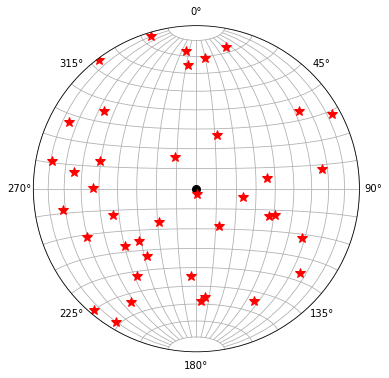

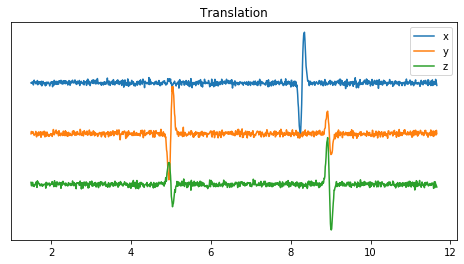

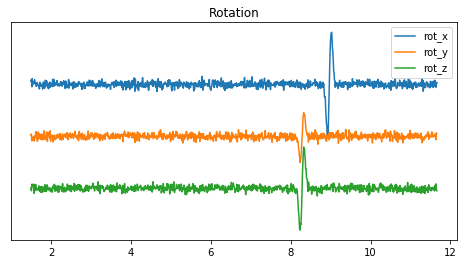

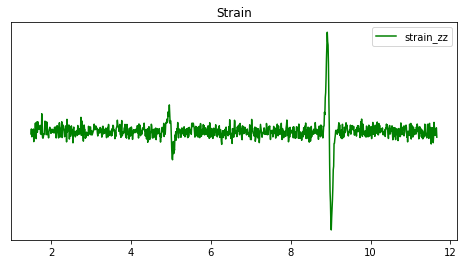

Used Events: 
 1) 0.825
 2) 0.825
 3) 0.825
 4) 0.825
 5) 0.825
 6) 1.0
 7) 1.0
 8) 1.0
 9) 0.8
10) 1.0
 
Misfit:
 1) 2.1131487631559382
 2) 1.4571102622184642
 3) 2.113896493442377
 4) 1.4567201008478323
 5) 2.064389060298738
 6) 0.8845696772005877
 7) 0.717568281057912
 8) 0.10053231811757517
 9) 1.2981450494320896
10) 3.3933210746961905e-14


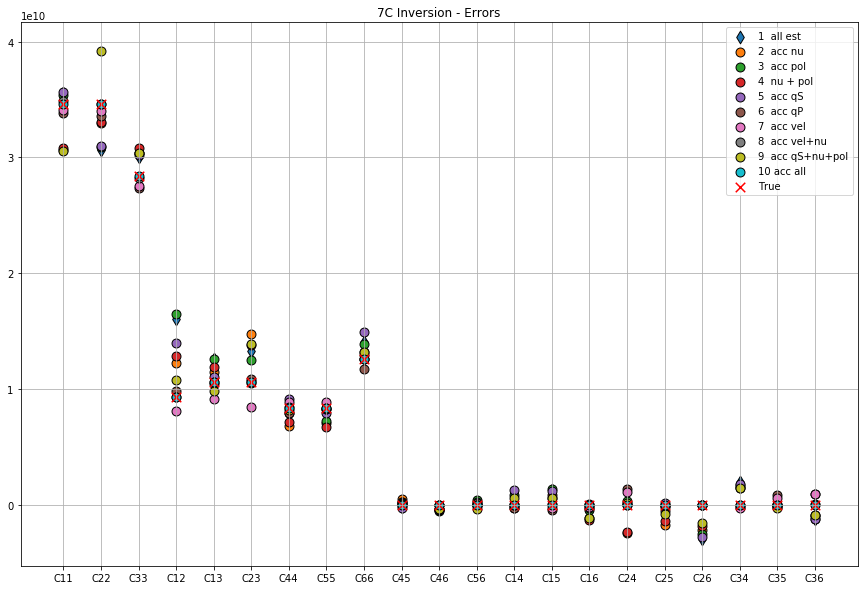

In [12]:
f = 15.
fs = 100.
SNR_dB_u = 10.
SNR_dB_r = 5.
SNR_dB_s = 5.
N = 40
min_vertical = 80.

## mode: assumed symmetry
mode = 'triclinic'

d1 = np.array([])
d2 = np.array([])
d3 = np.array([])
d4 = np.array([])
d5 = np.array([])
d6 = np.array([])
d7 = np.array([])
d8 = np.array([])
d9 = np.array([])
da = np.array([])

G1 = np.array([])
G2 = np.array([])
G3 = np.array([])
G4 = np.array([])
G5 = np.array([])
G6 = np.array([])
G7 = np.array([])
G8 = np.array([])
G9 = np.array([])
Ga = np.array([])

C_e1 = np.zeros((6,6))
C_e2 = np.zeros((6,6))
C_e3 = np.zeros((6,6))
C_e4 = np.zeros((6,6))
C_e5 = np.zeros((6,6))
C_e6 = np.zeros((6,6))
C_e7 = np.zeros((6,6))
C_e8 = np.zeros((6,6))
C_e9 = np.zeros((6,6))
C_ea = np.zeros((6,6))

nu_used1 = []
nu_used2 = []
nu_used3 = []
nu_used4 = []
nu_used5 = []
nu_used6 = []
nu_used7 = []
nu_used8 = []
nu_used9 = []
nu_useda = []

nus, gammas = get_direction('random',C,N+2,theta_e=0.,phi_e=0.)
plot_directions(nus[1:N+1])

all_seis = []
all_t = []
for i in range(1,N+1):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis_strain(v,vel,nus[i],f,fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=SNR_dB_s)
    seis = np.array([seis[0,:],seis[1,:],seis[2,:],seis[3,:],seis[4,:],seis[5,:],seis[8,:]])
    
    if i==1:
        plot_7C(seis,t)
    
    all_seis.append(seis)
    all_t.append(t)
    
    iqP = np.argmax(vel)
    iqS2 = np.argmin(vel)
    for l in range(0,3):
        if iqP!=l and iqS2!=l:
            iqS1 = l
    
    #1) no analytical results
    n_trans = get_polarizations(seis,'nav')
    nu_e = get_propagation_direction(seis,f,fs)
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t,min_vertical)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used1.append(nu_e)
        d1,G1 = add_new_data(mode,d1,G1,nu_e,vel_e,n_trans,density)
        
    #2) accurate propagation direction        
    n_trans = get_polarizations(seis,'nav')
    nu_e = nus[i]
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t,min_vertical)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used2.append(nu_e)
        d2,G2 = add_new_data(mode,d2,G2,nu_e,vel_e,n_trans,density)
    
    #3) accurate polarizations

    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = get_propagation_direction(seis,f,fs)
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t,min_vertical)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used3.append(nu_e)
        d3,G3 = add_new_data(mode,d3,G3,nu_e,vel_e,n_trans,density)
        
    #4) accurate propagation direction & polarizations
    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = nus[i]
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t,min_vertical)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used4.append(nu_e)
        d4,G4 = add_new_data(mode,d4,G4,nu_e,vel_e,n_trans,density)
        
    #5) accurate qS velocities
    
    n_trans = get_polarizations(seis,'nav')
    nu_e = get_propagation_direction(seis,f,fs)
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t,min_vertical)
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used5.append(nu_e)
        d5,G5 = add_new_data(mode,d5,G5,nu_e,vel_e,n_trans,density)
    
    #6) accurate qP velocity
    
    n_trans = get_polarizations(seis,'nav')
    nu_e = get_propagation_direction(seis,f,fs)
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t,min_vertical)
    
    vel_e[0] = vel[iqP]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used6.append(nu_e)
        d6,G6 = add_new_data(mode,d6,G6,nu_e,vel_e,n_trans,density)
        
    #7) accurate qP & qS velocities 
    
    n_trans = get_polarizations(seis,'nav')
    nu_e = get_propagation_direction(seis,f,fs)
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used7.append(nu_e)
        d7,G7 = add_new_data(mode,d7,G7,nu_e,vel_e,n_trans,density)
        
    #10) Accurate Solution
    
    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = nus[i]
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used8.append(nu_e)
        d8,G8 = add_new_data(mode,d8,G8,nu_e,vel_e,n_trans,density)
    
    #8) accurate velocities and prop. direction
    
    n_trans = get_polarizations(seis,'nav')
    nu_e = nus[i]
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used9.append(nu_e)
        d9,G9 = add_new_data(mode,d9,G9,nu_e,vel_e,n_trans,density)
        
    #9) Accurate qS & prop. direction & polarizations
    
    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = nus[i]
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t,min_vertical)
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_useda.append(nu_e)
        da,Ga = add_new_data(mode,da,Ga,nu_e,vel_e,n_trans,density)
    
    
    

Q1 = np.linalg.inv(np.dot(G1.transpose(),G1))         
m1 = np.dot(np.dot(Q1,G1.transpose()),d1)
C_e1 = sort_elastic_coeff(mode,m1)  
eps1 = np.dot(G1,m1) 

Q2 = np.linalg.inv(np.dot(G2.transpose(),G2))         
m2 = np.dot(np.dot(Q2,G2.transpose()),d2)
C_e2 = sort_elastic_coeff(mode,m2)  
eps2 = np.dot(G2,m2)

Q3 = np.linalg.inv(np.dot(G3.transpose(),G3))         
m3 = np.dot(np.dot(Q3,G3.transpose()),d3)
C_e3 = sort_elastic_coeff(mode,m3)  
eps3 = np.dot(G3,m3)

Q4 = np.linalg.inv(np.dot(G4.transpose(),G4))         
m4 = np.dot(np.dot(Q4,G4.transpose()),d4)
C_e4 = sort_elastic_coeff(mode,m4)  
eps4 = np.dot(G4,m4)

Q5 = np.linalg.inv(np.dot(G5.transpose(),G5))         
m5 = np.dot(np.dot(Q5,G5.transpose()),d5)
C_e5 = sort_elastic_coeff(mode,m5)  
eps5 = np.dot(G5,m5)

Q6 = np.linalg.inv(np.dot(G6.transpose(),G6))         
m6 = np.dot(np.dot(Q6,G6.transpose()),d6)
C_e6 = sort_elastic_coeff(mode,m6)  
eps6 = np.dot(G6,m6)

Q7 = np.linalg.inv(np.dot(G7.transpose(),G7))         
m7 = np.dot(np.dot(Q7,G7.transpose()),d7)
C_e7 = sort_elastic_coeff(mode,m7)  
eps7 = np.dot(G7,m7)

Q8 = np.linalg.inv(np.dot(G8.transpose(),G8))         
m8 = np.dot(np.dot(Q8,G8.transpose()),d8)
C_e8 = sort_elastic_coeff(mode,m8)  
eps8 = np.dot(G8,m8)

Q9 = np.linalg.inv(np.dot(G9.transpose(),G9))         
m9 = np.dot(np.dot(Q9,G9.transpose()),d9)
C_e9 = sort_elastic_coeff(mode,m9)  
eps9 = np.dot(G9,m9)

Qa = np.linalg.inv(np.dot(Ga.transpose(),Ga))         
ma = np.dot(np.dot(Qa,Ga.transpose()),da)
C_ea = sort_elastic_coeff(mode,ma)  
epsa = np.dot(Ga,ma) 
    
C = rotate_C(C,3,-ang3)
C = rotate_C(C,2,-ang2)
C = rotate_C(C,1,-ang1)

C_e1 = rotate_C(C_e1,3,-ang3)
C_e1 = rotate_C(C_e1,2,-ang2)
C_e1 = rotate_C(C_e1,1,-ang1)

C_e2 = rotate_C(C_e2,3,-ang3)
C_e2 = rotate_C(C_e2,2,-ang2)
C_e2 = rotate_C(C_e2,1,-ang1)

C_e3 = rotate_C(C_e3,3,-ang3)
C_e3 = rotate_C(C_e3,2,-ang2)
C_e3 = rotate_C(C_e3,1,-ang1)

C_e4 = rotate_C(C_e4,3,-ang3)
C_e4 = rotate_C(C_e4,2,-ang2)
C_e4 = rotate_C(C_e4,1,-ang1)

C_e5 = rotate_C(C_e5,3,-ang3)
C_e5 = rotate_C(C_e5,2,-ang2)
C_e5 = rotate_C(C_e5,1,-ang1)

C_e6 = rotate_C(C_e6,3,-ang3)
C_e6 = rotate_C(C_e6,2,-ang2)
C_e6 = rotate_C(C_e6,1,-ang1)

C_e7 = rotate_C(C_e7,3,-ang3)
C_e7 = rotate_C(C_e7,2,-ang2)
C_e7 = rotate_C(C_e7,1,-ang1)

C_e8 = rotate_C(C_e8,3,-ang3)
C_e8 = rotate_C(C_e8,2,-ang2)
C_e8 = rotate_C(C_e8,1,-ang1)

C_e9 = rotate_C(C_e9,3,-ang3)
C_e9 = rotate_C(C_e9,2,-ang2)
C_e9 = rotate_C(C_e9,1,-ang1)

C_ea = rotate_C(C_ea,3,-ang3)
C_ea = rotate_C(C_ea,2,-ang2)
C_ea = rotate_C(C_ea,1,-ang1)

print('Used Events: ')
print(' 1) '+str(len(nu_used1)/N))
print(' 2) '+str(len(nu_used2)/N))
print(' 3) '+str(len(nu_used3)/N))
print(' 4) '+str(len(nu_used4)/N))
print(' 5) '+str(len(nu_used5)/N))
print(' 6) '+str(len(nu_used6)/N))
print(' 7) '+str(len(nu_used7)/N))
print(' 8) '+str(len(nu_used9)/N))
print(' 9) '+str(len(nu_useda)/N))
print('10) '+str(len(nu_used8)/N))
print(' ')
    
print('Misfit:')
print(' 1) '+str(np.sqrt(np.dot(d1-eps1,d1-eps1))*1e-9/len(nu_used1)))
print(' 2) '+str(np.sqrt(np.dot(d2-eps2,d2-eps2))*1e-9/len(nu_used2)))
print(' 3) '+str(np.sqrt(np.dot(d3-eps3,d3-eps3))*1e-9/len(nu_used3)))
print(' 4) '+str(np.sqrt(np.dot(d4-eps4,d4-eps4))*1e-9/len(nu_used4)))
print(' 5) '+str(np.sqrt(np.dot(d5-eps5,d5-eps5))*1e-9/len(nu_used5)))
print(' 6) '+str(np.sqrt(np.dot(d6-eps6,d6-eps6))*1e-9/len(nu_used6)))
print(' 7) '+str(np.sqrt(np.dot(d7-eps7,d7-eps7))*1e-9/len(nu_used7)))
print(' 8) '+str(np.sqrt(np.dot(d9-eps9,d9-eps9))*1e-9/len(nu_used9)))
print(' 9) '+str(np.sqrt(np.dot(da-epsa,da-epsa))*1e-9/len(nu_useda)))
print('10) '+str(np.sqrt(np.dot(d8-eps8,d8-eps8))*1e-9/len(nu_used8)))


param = ['C11','C22','C33','C12','C13','C23','C44','C55','C66','C45','C46','C56','C14','C15','C16','C24',\
         'C25','C26','C34','C35','C36']
c_true = [C[0,0],C[1,1],C[2,2],C[0,1],C[0,2],C[1,2],C[3,3],C[4,4],C[5,5],C[3,4],C[3,5],C[4,5],C[0,3],C[0,4],\
          C[0,5],C[1,3],C[1,4],C[1,5],C[2,3],C[2,4],C[2,5]]
c_est1 = [C_e1[0,0],C_e1[1,1],C_e1[2,2],C_e1[0,1],C_e1[0,2],C_e1[1,2],C_e1[3,3],C_e1[4,4],C_e1[5,5],C_e1[3,4],\
         C_e1[3,5],C_e1[4,5],C_e1[0,3],C_e1[0,4],C_e1[0,5],C_e1[1,3],C_e1[1,4],C_e1[1,5],C_e1[2,3],C_e1[2,4],\
         C_e1[2,5]]
c_est2 = [C_e2[0,0],C_e2[1,1],C_e2[2,2],C_e2[0,1],C_e2[0,2],C_e2[1,2],C_e2[3,3],C_e2[4,4],C_e2[5,5],C_e2[3,4],\
          C_e2[3,5],C_e2[4,5],C_e2[0,3],C_e2[0,4],C_e2[0,5],C_e2[1,3],C_e2[1,4],C_e2[1,5],C_e2[2,3],C_e2[2,4],\
          C_e2[2,5]]
c_est3 = [C_e3[0,0],C_e3[1,1],C_e3[2,2],C_e3[0,1],C_e3[0,2],C_e3[1,2],C_e3[3,3],C_e3[4,4],C_e3[5,5],C_e3[3,4],\
          C_e3[3,5],C_e3[4,5],C_e3[0,3],C_e3[0,4],C_e3[0,5],C_e3[1,3],C_e3[1,4],C_e3[1,5],C_e3[2,3],C_e3[2,4],\
          C_e3[2,5]]
c_est4 = [C_e4[0,0],C_e4[1,1],C_e4[2,2],C_e4[0,1],C_e4[0,2],C_e4[1,2],C_e4[3,3],C_e4[4,4],C_e4[5,5],C_e4[3,4],\
          C_e4[3,5],C_e4[4,5],C_e4[0,3],C_e4[0,4],C_e4[0,5],C_e4[1,3],C_e4[1,4],C_e4[1,5],C_e4[2,3],C_e4[2,4],\
          C_e4[2,5]]
c_est5 = [C_e5[0,0],C_e5[1,1],C_e5[2,2],C_e5[0,1],C_e5[0,2],C_e5[1,2],C_e5[3,3],C_e5[4,4],C_e5[5,5],C_e5[3,4],\
          C_e5[3,5],C_e5[4,5],C_e5[0,3],C_e5[0,4],C_e5[0,5],C_e5[1,3],C_e5[1,4],C_e5[1,5],C_e5[2,3],C_e5[2,4],\
          C_e5[2,5]]
c_est6 = [C_e6[0,0],C_e6[1,1],C_e6[2,2],C_e6[0,1],C_e6[0,2],C_e6[1,2],C_e6[3,3],C_e6[4,4],C_e6[5,5],C_e6[3,4],\
          C_e6[3,5],C_e6[4,5],C_e6[0,3],C_e6[0,4],C_e6[0,5],C_e6[1,3],C_e6[1,4],C_e6[1,5],C_e6[2,3],C_e6[2,4],\
          C_e6[2,5]]
c_est7 = [C_e7[0,0],C_e7[1,1],C_e7[2,2],C_e7[0,1],C_e7[0,2],C_e7[1,2],C_e7[3,3],C_e7[4,4],C_e7[5,5],C_e7[3,4],\
          C_e7[3,5],C_e7[4,5],C_e7[0,3],C_e7[0,4],C_e7[0,5],C_e7[1,3],C_e7[1,4],C_e7[1,5],C_e7[2,3],C_e7[2,4],\
          C_e7[2,5]]
c_est8 = [C_e8[0,0],C_e8[1,1],C_e8[2,2],C_e8[0,1],C_e8[0,2],C_e8[1,2],C_e8[3,3],C_e8[4,4],C_e8[5,5],C_e8[3,4],\
          C_e8[3,5],C_e8[4,5],C_e8[0,3],C_e8[0,4],C_e8[0,5],C_e8[1,3],C_e8[1,4],C_e8[1,5],C_e8[2,3],C_e8[2,4],\
          C_e8[2,5]]

c_est9 = [C_e9[0,0],C_e9[1,1],C_e9[2,2],C_e9[0,1],C_e9[0,2],C_e9[1,2],C_e9[3,3],C_e9[4,4],C_e9[5,5],C_e9[3,4],\
          C_e9[3,5],C_e9[4,5],C_e9[0,3],C_e9[0,4],C_e9[0,5],C_e9[1,3],C_e9[1,4],C_e9[1,5],C_e9[2,3],C_e9[2,4],\
          C_e9[2,5]]

c_esta = [C_ea[0,0],C_ea[1,1],C_ea[2,2],C_ea[0,1],C_ea[0,2],C_ea[1,2],C_ea[3,3],C_ea[4,4],C_ea[5,5],C_ea[3,4],\
          C_ea[3,5],C_ea[4,5],C_ea[0,3],C_ea[0,4],C_ea[0,5],C_ea[1,3],C_ea[1,4],C_ea[1,5],C_ea[2,3],C_ea[2,4],\
          C_ea[2,5]]

plt.figure(figsize=(15,10))
plt.title('7C Inversion - Errors')
plt.scatter(param,c_est1,label='1  all est',marker='d',s=80,edgecolors='black')
plt.scatter(param,c_est2,label='2  acc nu',s=80,edgecolors='black')
plt.scatter(param,c_est3,label='3  acc pol',s=80,edgecolors='black')
plt.scatter(param,c_est4,label='4  nu + pol',s=80,edgecolors='black')
plt.scatter(param,c_est5,label='5  acc qS',s=80,edgecolors='black')
plt.scatter(param,c_est6,label='6  acc qP',s=80,edgecolors='black')
plt.scatter(param,c_est7,label='7  acc vel',s=80,edgecolors='black')
plt.scatter(param,c_est9,label='8  acc vel+nu',s=80,edgecolors='black')
plt.scatter(param,c_esta,label='9  acc qS+nu+pol',s=80,edgecolors='black')
plt.scatter(param,c_est8,label='10 acc all',s=80,edgecolors='black')
plt.scatter(param,c_true,color='red',marker='x',label='True',s=90,edgecolors='black')
plt.grid()
plt.legend(loc=1)
plt.show()

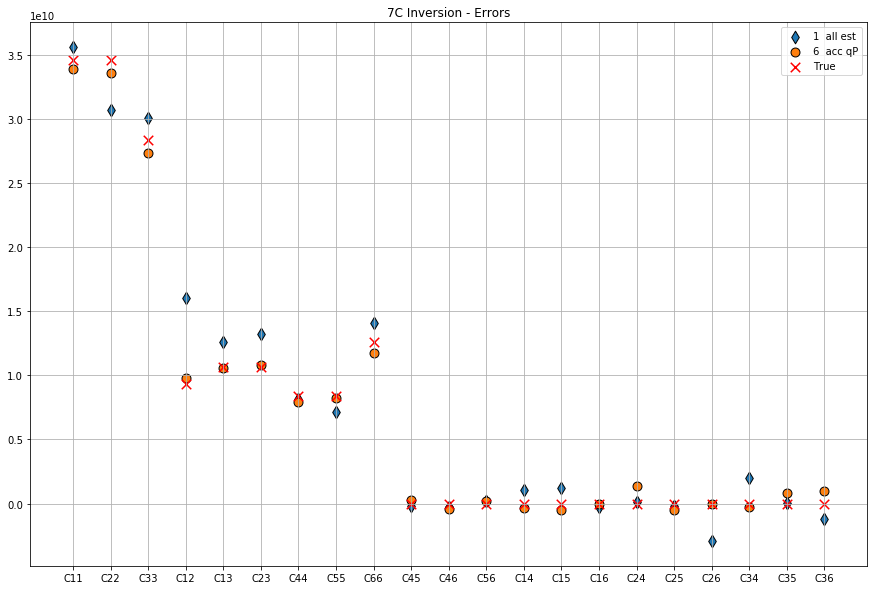

In [13]:
plt.figure(figsize=(15,10))
plt.title('7C Inversion - Errors')
plt.scatter(param,c_est1,label='1  all est',marker='d',s=80,edgecolors='black')
#plt.scatter(param,c_est2,label='2  acc nu',s=80,edgecolors='black')
#plt.scatter(param,c_est3,label='3  acc pol',s=80,edgecolors='black')
#plt.scatter(param,c_est4,label='4  nu + pol',s=80,edgecolors='black')
#plt.scatter(param,c_est5,label='5  acc qS',s=80,edgecolors='black')
plt.scatter(param,c_est6,label='6  acc qP',s=80,edgecolors='black')
#plt.scatter(param,c_est7,label='7  acc vel',s=80,edgecolors='black')
#plt.scatter(param,c_est9,label='8  acc vel+nu',s=80,edgecolors='black')
#plt.scatter(param,c_esta,label='9  acc qS+nu+pol',s=80,edgecolors='black')
#plt.scatter(param,c_est8,label='10 acc all',s=80,edgecolors='black')
plt.scatter(param,c_true,color='red',marker='x',label='True',s=90,edgecolors='black')
plt.grid()
plt.legend(loc=1)
plt.show()